In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Add, LayerNormalization, Dropout
from tensorflow.keras.layers import Embedding, TimeDistributed, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

#### ChatBotData
- 11823개 문답 pair
- label: 0-일상다반사, 1-이별(부정), 2-사랑(긍정)

In [6]:
# chatBotData = pd.read_csv('/content/drive/My Drive/멀티캠퍼스/머신러닝/4. 자연어처리(딥러닝)/내폴더/08.11(화)/Seq2Seq/dataset/6-1.ChatBotData.csv')
chatBotData = pd.read_csv("/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님/dataset/6-1.ChatBotData.csv")
chatBotData.head(2)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0


In [7]:
PAD = "<PADDING>"
STD = "<START>"
END = "<END>"
OOV = "<OOV>"
MARKER = [PAD, STD, END, OOV]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([chatBotData['Q'], chatBotData['A']], axis=0))
word2idx =  list(tokenizer.word_index.keys())
word2idx[:0] = MARKER
word2idx = {word: idx for idx, word in enumerate(word2idx)}
tokenizer.word_index = word2idx
idx2word = {idx: word for word, idx in word2idx.items()}

chatBotData['Q'] = tokenizer.texts_to_sequences(chatBotData['Q'])
chatBotData['A'] = tokenizer.texts_to_sequences(chatBotData['A'])

#### Preprocessing
- 문장의 최대 단어 개수를 제한
- Source(Question), Target(<START> + Answer), Output(Answer + <END>)로 나눈다
- Padding 처리

In [8]:
MAX_SEQUENCE_LEN = 10

def padding(x):
    if (MAX_SEQUENCE_LEN - len(x)) > 0:
        x += (MAX_SEQUENCE_LEN - len(x)) * [word2idx[PAD]]
    return x

data = pd.DataFrame()
data['Source'] = chatBotData['Q'].apply(lambda x: padding(x[:MAX_SEQUENCE_LEN]))
data['Target'] = chatBotData['A'].apply(lambda x: padding([word2idx[STD]] + x[:MAX_SEQUENCE_LEN]) if len(x) < MAX_SEQUENCE_LEN else padding([word2idx[STD]] + x[:MAX_SEQUENCE_LEN-1]))
data['Output'] = chatBotData['A'].apply(lambda x: padding(x[:MAX_SEQUENCE_LEN] + [word2idx[END]]) if len(x) < MAX_SEQUENCE_LEN else padding(x[:MAX_SEQUENCE_LEN-1] + [word2idx[END]]))

#### Train, Test Data 분리
-  random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.

In [9]:
trainSource, testSource, trainTarget, testTarget, trainOutput, testOutput = \
        [np.vstack(d) for d in train_test_split(data['Source'].values, data['Target'].values, data['Output'].values, test_size=0.2, random_state=42)]

# Inputs + Encoder

## Positional Encoding
- trainSource.shape: (None, MAX_SEQUENCE_LEN)
- Embeding Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- Positional Encoding Layer shape: (MAX_SEQUENCE_LEN, EMB_SIZE)

In [10]:
def get_angles(position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    # pos_encoding = pos_encoding[tf.newaxis, ...]

    return tf.cast(pos_encoding, tf.float32)

## Positional Encoding + Source Embedding Layer
- [Input] Embeding Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Positional Encoding Layer shape: (MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Encoded Inputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [11]:
VOCAB_SIZE = len(idx2word)
EMB_SIZE = 128

inputs = Input(batch_shape=(None, trainSource.shape[1]), name='inputs')
inputEmbedding = Embedding(VOCAB_SIZE, EMB_SIZE, name='inputEmbedding')(inputs)
encoded_inputs = tf.add(positional_encoding(MAX_SEQUENCE_LEN, EMB_SIZE), inputEmbedding, name='encoded_inputs')
encoded_inputs.shape
# # embeddings.shape

TensorShape([None, 10, 128])

## Encoder Multi Head Attention
- [Input] Encoded Inputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] multi head attention shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [12]:
num_heads = 4
model_dim = EMB_SIZE
key_dim = EMB_SIZE // num_heads
value_dim = EMB_SIZE // num_heads

def linear_projection(encPrevLayer, decPrevLayer):
    q = Dense(key_dim, use_bias=False)(encPrevLayer)
    k = Dense(key_dim, use_bias=False)(encPrevLayer)
    v = Dense(key_dim, use_bias=False)(decPrevLayer)

    return q, k, v

def split_heads(q, k, v):
    def split_last_dimension_then_transpose(tensor, num_heads):
        tensor = K.expand_dims(tensor, axis=1)
        return K.repeat_elements(tensor,rep=num_heads, axis=1)
    
    qs = split_last_dimension_then_transpose(q, num_heads)
    ks = split_last_dimension_then_transpose(k, num_heads)
    vs = split_last_dimension_then_transpose(v, num_heads)

    return qs, ks, vs


encQ, encK, encV = linear_projection(encoded_inputs, encoded_inputs)
encQs, encKs, encVs = split_heads(encQ, encK, encV)
encQs.shape, encKs.shape, encVs.shape

(TensorShape([None, 4, 10, 32]),
 TensorShape([None, 4, 10, 32]),
 TensorShape([None, 4, 10, 32]))

In [13]:
def _scaled_dot_product(qs, ks, vs, key_dim, masked):
    '''
    qs: (batch_size, num_heads, max_seq_len, dim)
    ks: (batch_size, num_heads, max_seq_len, dim)
    vs: (batch_size, num_heads, max_seq_len, dim)
    '''
    o1 = tf.matmul(qs, ks, transpose_b=True)    # Q * (K^T)
    o2 = o1 / (key_dim ** 0.5)                  # Q * (K^T) / (dk^(1/2))

    if masked:
        diag_vals = tf.ones_like(o2[0, 0, :, :])
        tril = tf.linalg.LinearOperatorLowerTriangular(diag_vals).to_dense() # 하삼각행렬: 자기 자신인 단어까지만.
        masks = tf.tile(input=tf.reshape(tril, (1, 1, tril.shape[0], tril.shape[1])), \
                        multiples=[tf.shape(o2)[0], tf.shape(o2)[1], 1, 1]) # batch size, num_heads 만큼 행렬 사이즈 늘려서 마스크 만듦.
        paddings = tf.ones_like(masks) * -1e9 # 주목하지 말아야 할 부분에 낮은 숫자.
        o2 = tf.where(tf.equal(masks, 0), paddings, o2) # mask에 0인 위치(뒤의 단어)에 패딩을 넣어 준다.

    o3 = Activation('softmax')(o2)              # softmax
    o3 = tf.matmul(o3, vs)
    
    return o3

def _concat_heads(outputs):
    def transpose_then_concat_last_two_dimension(tensor):
        return tf.reshape(tensor, shape=(-1, tensor.shape[2], tensor.shape[1]*tensor.shape[3]))
    return transpose_then_concat_last_two_dimension(outputs)

encAttValue = _scaled_dot_product(encQs, encKs, encVs, key_dim, False)
encConAttValue = _concat_heads(encAttValue)
encConAttValue.shape

TensorShape([None, 10, 128])

## Encoder Add & Norm 1st
- [Input] multi head attention shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Encoded Inputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Add And Norm Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [14]:
addEnc1 = Add(name='addEnc1')([encConAttValue, encoded_inputs])
addNormEnc1 = LayerNormalization(name='addNormEnc1')(addEnc1)
addNormEnc1.shape

TensorShape([None, 10, 128])

## Encoder FFN + Add & Norm 2nd
- [Input] Add And Norm Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Encoder Output shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [15]:
w1_dim=200
w2_dim=128
dropout=0.1

encFFN = Dense(w1_dim, activation='relu', name='encFFN_1') (addNormEnc1)
encFFN = Dense(w2_dim, name='encFFN_2') (encFFN)
encFFNDropout = Dropout(1.0 - dropout, name='encFFNDropout')(encFFN)

In [16]:
addEnc2 = Add(name='addEnc2')([addNormEnc1, encFFNDropout])
addNormEnc2 = LayerNormalization(name='addNormEnc2')(addEnc2)
addNormEnc2.shape

TensorShape([None, 10, 128])

# Outputs + Decoder

## Positional Encoding + Target Embedding Layer
- [Input] Embeding Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Positional Encoding Layer shape: (MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Encoded Outputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [17]:
outputs = Input(batch_shape=(None, trainTarget.shape[1]), name='outputs')
outputEmbedding = Embedding(VOCAB_SIZE, EMB_SIZE, name='outputEmbedding')(outputs)
encoded_outputs = tf.add(positional_encoding(MAX_SEQUENCE_LEN, EMB_SIZE), outputEmbedding, name='encoded_outputs')
encoded_outputs.shape

TensorShape([None, 10, 128])

## Decoder Masked Multi Head Attention
- [Input] Encoded Outputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] masked multi head attention shape: (None, head, MAX_SEQUENCE_LEN, EMB_SIZE)

In [18]:
decMaskedQ, decMaskedK, decMaskedV = linear_projection(encoded_outputs, encoded_outputs)
decMaskedQs, decMaskedKs, decMaskedVs = split_heads(decMaskedQ, decMaskedK, decMaskedV)

decMaskedAttValue = _scaled_dot_product(decMaskedQs, decMaskedKs, decMaskedVs, key_dim, True)
decMaskedConAttValue = _concat_heads(decMaskedAttValue)
decMaskedConAttValue.shape

TensorShape([None, 10, 128])

## Decoder Add & Norm 1st
- [Input] masked multi head attention shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Encoded Outputs shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Decoder Add And Norm 1st Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [19]:
addDec1 = Add(name='addDec1')([decMaskedConAttValue, encoded_outputs])
addNormDec1 = LayerNormalization(name='addNormDec1')(addDec1)
addNormDec1.shape

TensorShape([None, 10, 128])

## Decoder Multi Head Attention
- [Input] Encoder Output shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Decoder Add & Norm 1st Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Decoder multi head attention shape: (None, head, MAX_SEQUENCE_LEN, EMB_SIZE)

In [20]:
decQ, decK, decV = linear_projection(addNormEnc2, addNormDec1)
decQs, decKs, decVs = split_heads(decQ, decK, decV)

decAttValue = _scaled_dot_product(decQs, decKs, decVs, key_dim, False)
decConAttValue = _concat_heads(decAttValue)
decConAttValue.shape

TensorShape([None, 10, 128])

## Decoder Add & Norm 2nd
- [Input] Decoder Add And Norm 1st Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Input] Decoder multi head attention shape: (None, head, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Decoder Add And Norm 2nd Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [21]:
addDec2 = Add(name='addDec2')([decConAttValue, addNormDec1])
addNormDec2 = LayerNormalization(name='addNormDec2')(addDec2)
addNormDec2.shape

TensorShape([None, 10, 128])

## Decoder FFN + Add & Norm 3rd
- [Input] Decoder Add And Norm 2nd Layer shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)
- [Output] Decoder Output shape: (None, MAX_SEQUENCE_LEN, EMB_SIZE)

In [22]:
w1_dim=200
w2_dim=128
dropout=0.1

decFFN = Dense(w1_dim, activation='relu', name='decFFN_1') (addNormDec2)
decFFN = Dense(w2_dim, name='decFFN_2') (decFFN)
decFFNDropout = Dropout(1.0 - dropout, name='decFFNDropout')(decFFN)

In [23]:
addDec3 = Add(name='addDec3')([addNormDec2, decFFNDropout])
addNormDec3 = LayerNormalization(name='addNormDec3')(addDec3)
addNormDec3.shape

TensorShape([None, 10, 128])

# Linear + Softmax

In [24]:
linearLayer = Dense(VOCAB_SIZE, name='linearLayer')(addNormDec3)
OutputProb = Dense(VOCAB_SIZE, activation='softmax', name='OutputProb')(linearLayer)

# Model Train

In [25]:
model = Model([inputs, outputs], OutputProb)
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
outputs (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
outputEmbedding (Embedding)     (None, 10, 128)      2648192     outputs[0][0]                    
__________________________________________________________________________________________________
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_encoded_outputs (Te [(None, 10, 128)]    0           outputEmbedding[0][0]            
_______________________________________________________________________________________

Epoch 1/100
19/19 [==============================] - 36s 2s/step - loss: 5.6372 - val_loss: 5.9289
Epoch 2/100
19/19 [==============================] - 35s 2s/step - loss: 3.8197 - val_loss: 5.2375
Epoch 3/100
19/19 [==============================] - 35s 2s/step - loss: 3.5292 - val_loss: 4.4817
Epoch 4/100
19/19 [==============================] - 35s 2s/step - loss: 3.2146 - val_loss: 3.5347
Epoch 5/100
19/19 [==============================] - 35s 2s/step - loss: 2.9421 - val_loss: 3.1448
Epoch 6/100
19/19 [==============================] - 35s 2s/step - loss: 2.7658 - val_loss: 3.0199
Epoch 7/100
19/19 [==============================] - 36s 2s/step - loss: 2.6061 - val_loss: 3.0222
Epoch 8/100
19/19 [==============================] - 35s 2s/step - loss: 2.4465 - val_loss: 2.8007
Epoch 9/100
19/19 [==============================] - 36s 2s/step - loss: 2.1795 - val_loss: 2.5651
Epoch 10/100
19/19 [==============================] - 35s 2s/step - loss: 1.8403 - val_loss: 2.3524
Epoch 11/

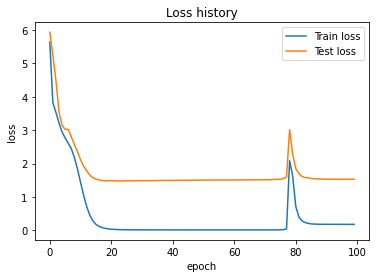

In [26]:
hist = model.fit([trainSource, trainTarget], trainOutput,
                 batch_size = 500, 
                 epochs=100, 
                 shuffle=True,
                 validation_data = ([testSource, testTarget], testOutput))

# Loss history
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Model Predict

## 인코더

In [27]:
# 인코더 모델
model_enc = Model(inputs, addNormEnc2)
model_enc.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
inputEmbedding (Embedding)      (None, 10, 128)      2648192     inputs[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_encoded_inputs (Ten [(None, 10, 128)]    0           inputEmbedding[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 32)       4096        tf_op_layer_encoded_inputs[0][0] 
_______________________________________________________________________________________

In [29]:
# Question을 입력받아 Answer 생성
def genAnswer(question):
    question = question.reshape(-1, MAX_SEQUENCE_LEN)
    print(f"question: {question}")    

    # 시작 단어 <START> 초기화
    answer = np.zeros(10).reshape(-1, MAX_SEQUENCE_LEN)
    answer[0][0] = word2idx['<START>']
    print(f"answer: {answer}")

    for i in range(MAX_SEQUENCE_LEN):
        pred = model.predict([question, answer])
        # print(pred[0][i])
        # print(pred[0][i+1])
        # print(pred[0][i+1].shape)
        # break
        nextWord = np.argmax(pred[0][i+1])
        print(nextWord)
        
        if nextWord == word2idx['<END>'] or nextWord == word2idx['<PADDING>']:
            break
        
        # 다음 예상 단어에 answer 추가
        answer[0][i+1] = nextWord 
    
    return " ".join([idx2word[an] for an in answer[0]])

In [30]:
# Chatting
def chatting(n=100):
    for i in range(n):
        question = input('Q : ')
        
        if  question == 'quit':
            break
        
        q_idx = []
        for x in question.split(' '):
            if x in word2idx:
                q_idx.append(word2idx[x])
            else:
                q_idx.append(word2idx['<OOV>'])   # out-of-vocabulary (OOV)
        
        # <PADDING>을 삽입한다.
        if len(q_idx) < MAX_SEQUENCE_LEN:
            q_idx.extend([word2idx['<PADDING>']] * (MAX_SEQUENCE_LEN - len(q_idx)))
        else:
            q_idx = q_idx[0:MAX_SEQUENCE_LEN]
        
        answer = genAnswer(np.array(q_idx))
        print('A :', answer)

chatting(100)

Q : 가끔 궁금해
question: [[390 585   0   0   0   0   0   0   0   0]]
answer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
A : <START> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>
Q : <PADDING>
question: [[0 0 0 0 0 0 0 0 0 0]]
answer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
A : <START> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>
Q : 뭐가 문제인가
question: [[291   3   0   0   0   0   0   0   0   0]]
answer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
A : <START> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>
Q : 양지인씨 안갔네?
question: [[3 3 0 0 0 0 0 0 0 0]]
answer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
A : <START> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>
Q : 아 스터디룸 갔구나 이사람들
question: [[511   3   3   3   0   0   0   0   0   0]]
answer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
A : <START> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>

KeyboardInterrupt: ignored